In [50]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use("seaborn")


%matplotlib inline

from sklearn.model_selection import train_test_split
from google.colab import drive
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from base64 import b64encode
from IPython.display import HTML
from tensorflow.keras.callbacks import EarlyStopping

<ipython-input-50-2bc42a3cf532>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

# Classes Directories
drive_root = '/content/gdrive/MyDrive/violence-detection-dataset'  # Update this with the path to your main folder on Google Drive

NonViolenceVideos_Dir_cam1 = os.path.join(drive_root, 'non-violent/cam1/')
NonViolenceVideos_Dir_cam2 = os.path.join(drive_root, 'non-violent/cam2/')

ViolenceVideos_Dir_cam1 = os.path.join(drive_root, 'violent/cam1/')
ViolenceVideos_Dir_cam2 = os.path.join(drive_root, 'violent/cam2/')

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list_cam1 = os.listdir(NonViolenceVideos_Dir_cam1)
NonViolence_files_names_list_cam2 = os.listdir(NonViolenceVideos_Dir_cam2)

Violence_files_names_list_cam1 = os.listdir(ViolenceVideos_Dir_cam1)
Violence_files_names_list_cam2 = os.listdir(ViolenceVideos_Dir_cam2)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video_cam1 = random.choice(NonViolence_files_names_list_cam1)
Random_NonViolence_Video_cam2 = random.choice(NonViolence_files_names_list_cam2)

Random_Violence_Video_cam1 = random.choice(Violence_files_names_list_cam1)
Random_Violence_Video_cam2 = random.choice(Violence_files_names_list_cam2)





In [ ]:
# Play the randomly selected videos
Play_Video(os.path.join(NonViolenceVideos_Dir_cam1, Random_NonViolence_Video_cam1))
Play_Video(os.path.join(NonViolenceVideos_Dir_cam2, Random_NonViolence_Video_cam2))

Play_Video(os.path.join(ViolenceVideos_Dir_cam1, Random_Violence_Video_cam1))
Play_Video(os.path.join(ViolenceVideos_Dir_cam2, Random_Violence_Video_cam2))

In [ ]:
action_occurrences = pd.read_csv('/content/gdrive/MyDrive/violence-detection-dataset/action-class-occurrences.csv')
non_violent_actions = pd.read_csv('/content/gdrive/MyDrive/violence-detection-dataset/nonviolent-action-classes.csv', na_values=['NA', 'N/A'], delimiter=';')
violent_actions = pd.read_csv('/content/gdrive/MyDrive/violence-detection-dataset/violent-action-classes.csv', na_values=['NA', 'N/A'], delimiter=';')

In [ ]:
# Dynamically detect the column names for violent and action class
if len(action_occurrences.columns) == 1:
    # Assuming the only column is for action class (no separate column for 'VIOLENT')
    violent_column = None
    action_class_column = action_occurrences.columns[0]
else:
    violent_column = action_occurrences.columns[1]  # Assuming 'y' or 'n' for violent
    action_class_column = action_occurrences.columns[0]  # Assuming this column contains action classes

# Create label mapping
label_mapping = {}
for _, row in action_occurrences.iterrows():
    label_mapping[row[action_class_column]] = 1 if violent_column is None else (1 if row[violent_column] == 'y' else 0)

In [26]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16


DATASET_DIR = "/content/gdrive/MyDrive/violence-detection-dataset"

CLASSES_LIST = ["non-violent", "violent"]

In [27]:
def frames_extraction(video_path):

    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list


In [33]:
import os
import time
import numpy as np

def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        # Get the relevant labeled data for the current class
        if class_name == "non-violent":
            class_data = non_violent_actions
        elif class_name == "violent":
            class_data = violent_actions
        else:
            # Handle other classes if needed
            continue

        # Iterate through the rows of the labeled data
        for _, row in class_data.iterrows():
            for camera in ["cam1", "cam2"]:
                # Get the complete video path
                video_file_path = os.path.join(DATASET_DIR, class_name, camera, row['FILE'])
                print(video_file_path)

                # Measure the time before frame extraction
                start_time = time.time()

                # Extract the frames of the video file
                frames = frames_extraction(video_file_path)

                # Measure the time after frame extraction
                end_time = time.time()

                # Check if the extracted frames match the SEQUENCE_LENGTH
                if len(frames) == SEQUENCE_LENGTH:
                    # Append the data to their respective lists
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)

                    # Print time taken for extraction
                    extraction_time = end_time - start_time
                    print(f"{video_file_path} Extraction Done (Time: {extraction_time:.2f} seconds)")

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths


In [34]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: non-violent
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam1/1.mp4
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam1/1.mp4 Extraction Done (Time: 12.79 seconds)
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam2/1.mp4
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam2/1.mp4 Extraction Done (Time: 10.89 seconds)
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam1/2.mp4
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam1/2.mp4 Extraction Done (Time: 11.33 seconds)
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam2/2.mp4
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam2/2.mp4 Extraction Done (Time: 9.85 seconds)
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam1/3.mp4
/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam1/3.mp4 Extraction Done (Time: 11.51 seconds)
/content/gdrive/MyDrive/violence-

In [35]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [36]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

In [37]:
print("Labels:", labels)
print("Labels Shape:", labels.shape)

Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels Shape: (350,)


In [39]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [40]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2,
                                                                            shuffle = True, random_state = 42)

In [41]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(280, 16, 64, 64, 3) (280, 2)
(70, 16, 64, 64, 3) (70, 2)


In [42]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

#mobilenet.summary()

9406464/9406464 [==============================] - 0s 0us/step


In [47]:
def create_model():

    model = Sequential()

    ########################################################################################################################

    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))

    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))


    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))

    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

        ########################################################################################################################

    model.summary()

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

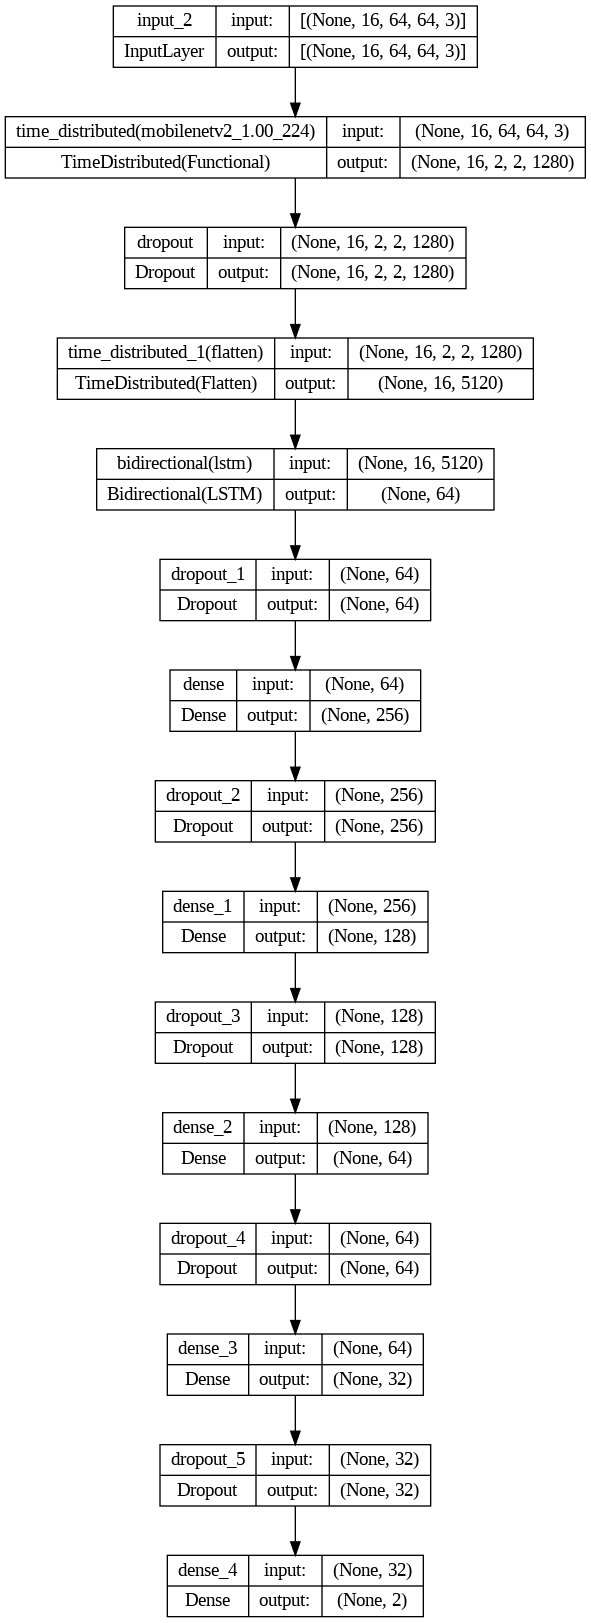

In [48]:
# Constructing the Model
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [53]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

# Compiling the model
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

# Fitting the model
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 13, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/13
28/28 [==============================] - 57s 2s/step - loss: 0.0918 - accuracy: 0.9732 - val_loss: 0.2865 - val_accuracy: 0.8929 - lr: 0.0100
Epoch 2/13
28/28 [==============================] - 39s 1s/step - loss: 0.0684 - accuracy: 0.9777 - val_loss: 0.1994 - val_accuracy: 0.9286 - lr: 0.0100
Epoch 3/13
28/28 [==============================] - 40s 1s/step - loss: 0.0676 - accuracy: 0.9866 - val_loss: 0.2783 - val_accuracy: 0.9107 - lr: 0.0100
Epoch 4/13
28/28 [==============================] - 39s 1s/step - loss: 0.0283 - accuracy: 0.9955 - val_loss: 0.2693 - val_accuracy: 0.9107 - lr: 0.0100
Epoch 5/13
28/28 [==============================] - 41s 1s/step - loss: 0.0751 - accuracy: 0.9732 - val_loss: 0.3506 - val_accuracy: 0.8750 - lr: 0.0100
Epoch 6/13
28/28 [==============================] - 38s 1s/step - loss: 0.1376 - accuracy: 0.9509 - val_loss: 0.6255 - val_accuracy: 0.7857 - lr: 0.0100
Epoch 7/13
28/28 [==============================] - ETA: 0s - loss: 0.1544 - accur

In [54]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

3/3 [==============================] - 9s 2s/step - loss: 0.5971 - accuracy: 0.8429


In [55]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

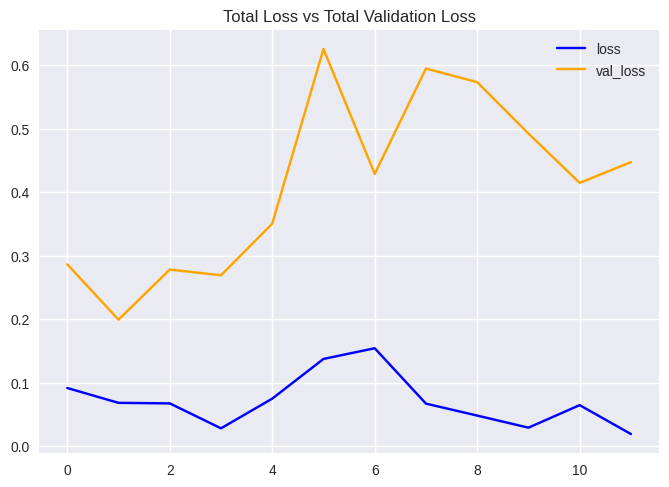

In [56]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

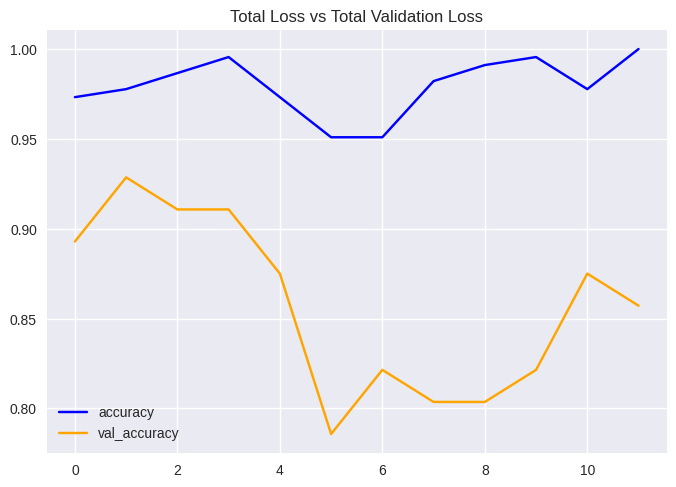

In [57]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [58]:
labels_predict = MoBiLSTM_model.predict(features_test)

3/3 [==============================] - 10s 1s/step


In [59]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [60]:
labels_test_normal.shape , labels_predict.shape

((70,), (70,))

In [61]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8428571428571429


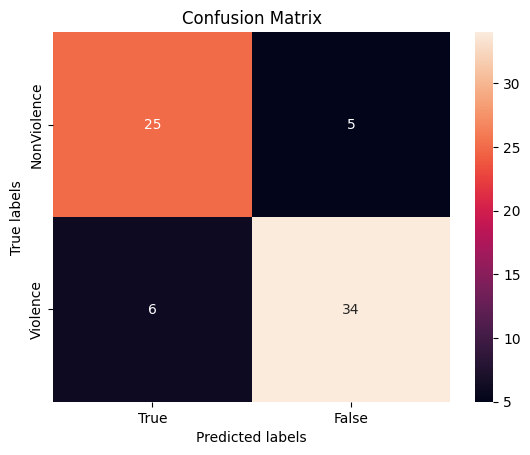

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [67]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.81      0.83      0.82        30
           1       0.87      0.85      0.86        40

    accuracy                           0.84        70
   macro avg       0.84      0.84      0.84        70
weighted avg       0.84      0.84      0.84        70



In [68]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):

    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)

        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [69]:
plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path):

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))

    for counter, random_index in enumerate(random_range, 1):

        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)

        ok, frame = video_reader.read()

        if not ok:
          break

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()

    video_reader.release()

In [70]:
# Construct the output video path.
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

1/1 [==============================] - 0s 144ms/step


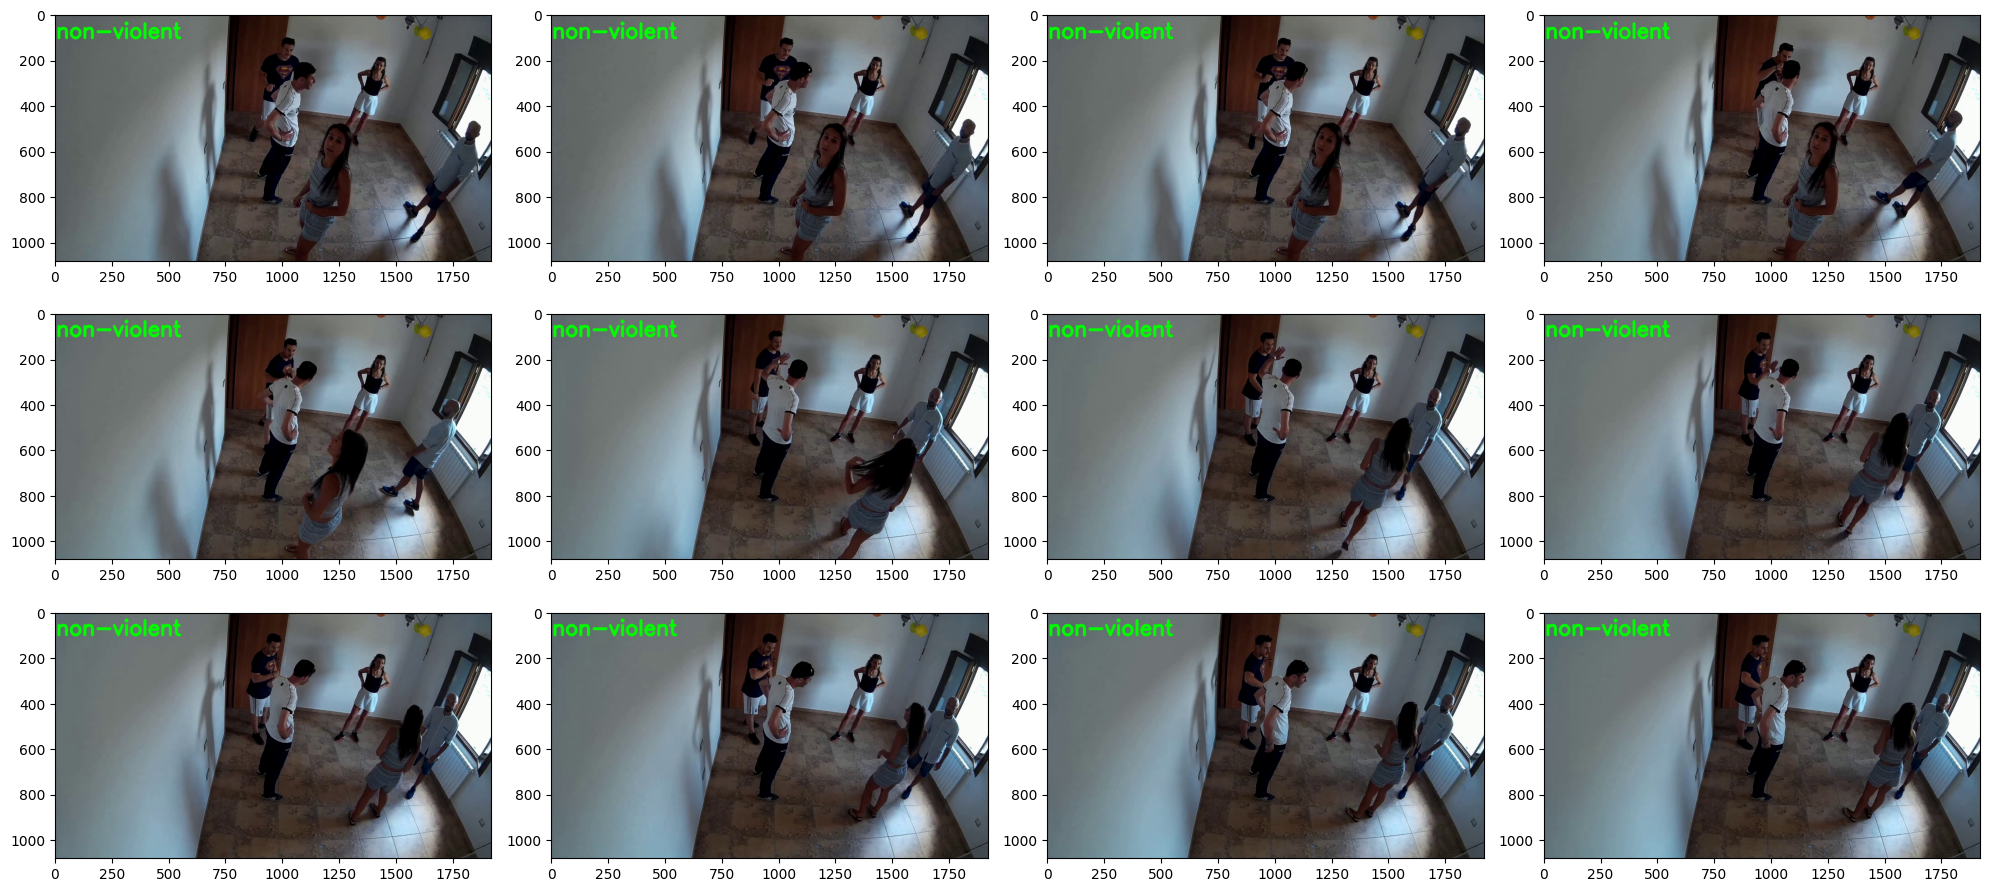

In [72]:
# Specifying video to be predicted
input_video_file_path = "/content/gdrive/MyDrive/violence-detection-dataset/non-violent/cam2/14.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)